In [3]:
import time
import numpy as np
import pandas as pd
import datetime as datetime

import matplotlib.pyplot as plt

import yfinance as yf # Must be v0.1.83: https://github.com/ranaroussi/yfinance/issues/1484
import talib as ta

import warnings

# you'll also need pytables installed:
# conda install pytables

# suppress the PerformanceWarning
warnings.simplefilter('ignore')

In [162]:
# Build S&P500 dataset with 103 features (6 raw market observations, and 97 technical indicators)
# Deep Learning, Spring 2023
# Derek M. Shore, dshore3

In [ ]:
# Get list of all stock tickers that have EVER been in the S&P 500.
# https://medium.com/wealthy-bytes/5-lines-of-python-to-automate-getting-the-s-p-500-95a632e5e567 
sp500_tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]["Symbol"].tolist()
sp500_tickers.sort()

In [ ]:
# Let's grab data from the last 40 years.
start="1982-04-09"
end="2023-04-09"

data_dict = {}

In [ ]:
# Download 40 years worth of stock data for each ticker.
# Note: I've added a 2-second sleep to avoid hitting API
# download limits.

for i,ticker in enumerate(sp500_tickers):
    print(str(i) + " " + ticker)
    
    if ticker in data_dict.keys():
        print("Already downloaded!\n")
        continue 
        
    if ticker in ['BRK.B', 'BF.B']:
        print("Problematic ticker\n")
        continue
    
    temp_data = yf.download(ticker, start=start, end=end)
    data_dict[ticker] = temp_data
    print()
    time.sleep(2)

In [ ]:
# Organize DataFrame hierarchy
data_df = pd.concat(data_dict.values(), axis=1, keys=data_dict.keys())
data_df = data_df.swaplevel(axis=1)
data_df = data_df.sort_index(axis=1, level=[0, 1])
data_df_sorted = data_df.sort_index()

In [ ]:
# View DataFrame
#data_df

In [ ]:
# Write raw ticker data to file.
data_df_sorted.to_csv('raw_stock_data.csv')

In [159]:
# Read raw ticker data to file.
new_data_df = pd.read_csv('raw_stock_data.csv', header=[0, 1], index_col=[0])

# Forward fill then backfill data.
# https://www.omscs-notes.com/machine-learning-trading/incomplete-data/
data_df_forward_fill_then_back_fill = new_data_df.fillna(method="ffill")
data_df_forward_fill_then_back_fill = data_df_forward_fill_then_back_fill.fillna(method="bfill")

# Calculate % change. Drop the first row, because the % change isn't established yet.
data_df_forward_fill_then_back_fill = data_df_forward_fill_then_back_fill.pct_change()[1:]

# Write filled data to file. Notice I've switched to .h5 for performance gains.
data_df_forward_fill_then_back_fill.to_hdf('forward_fill_then_back_fill_stock_data.h5', key='data')

In [161]:
# Re-reading in the data to help with memory continuity--not sure if this really helps!
# This was done in response to some of warning I received when manipulating the DataFrame.
loaded_filled_data = pd.read_hdf('forward_fill_then_back_fill_stock_data.h5', key='data')
cleaned_data = loaded_filled_data.reset_index()
cleaned_data.index = cleaned_data['Date']
cleaned_data = cleaned_data.drop('Date', axis=1)

data_with_TAs = cleaned_data

In [ ]:
# Calculate technical indicators that just use 'Adj Close'
functions = [ta.DEMA, ta.EMA, ta.HT_TRENDLINE, ta.KAMA, ta.MA, ta.MIDPOINT, ta.SMA, ta.T3, 
             ta.TEMA, ta.TRIMA, ta.WMA, ta.CMO, ta.MOM, ta.PPO, ta.ROC, ta.ROCP, ta.ROCR,
             ta.ROCR100, ta.RSI, ta.TRIX, ta.HT_DCPERIOD, ta.HT_DCPHASE, ta.HT_TRENDMODE]

function_names = ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MIDPOINT', 'SMA', 'T3', 
             'TEMA', 'TRIMA', 'WMA', 'CMO', 'MOM', 'PPO', 'ROC', 'ROCP', 'ROCR', 
             'ROCR100', 'RSI', 'TRIX', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_TRENDMODE' ]

for this_index, this_ta_name in enumerate(function_names):
     
    # This allows us to re-run the cell without losing progress, just in case something 
    # goes wrong in the for loop.
    if this_ta_name in data_with_TAs.keys():
        continue

    print(this_ta_name)
    print()
    
    # Create DataFrame to hold this indicator's values.
    TA_df = pd.DataFrame()

    for ticker in data_with_TAs['Adj Close'].keys():
        TA_df[ticker] = functions[this_index](data_with_TAs['Adj Close'][ticker])

    # Merge technical indicator data with main DataFrame.
    cols = pd.MultiIndex.from_product([[this_ta_name], TA_df.keys()])
    TA_df.columns = cols
    data_with_TAs = pd.merge(data_with_TAs,TA_df, on='Date')

In [ ]:
# Calculate technical indicators that use 'High' and 'Low'
functions = [ta.MIDPOINT, ta.SAR, ta.SAREXT, ta.AROONOSC, ta.MINUS_DM,
             ta.PLUS_DM, ta.MEDPRICE ]

function_names = ['MIDPOINT', 'SAR', 'SAREXT', 'AROONOSC', 'MINUS_DM',
             'PLUS_DM', 'MEDPRICE']

# 'STOCH', 'STOCHF' were problematic, so they were not included

for this_index, this_ta_name in enumerate(function_names):
    
    # This allows us to re-run the cell without losing progress, just in case something 
    # goes wrong in the for loop.
    if this_ta_name in data_with_TAs.keys():
        continue
    
    print(this_ta_name)
    print()
    
    # Create DataFrame to hold this indicator's values.
    TA_df = pd.DataFrame()

    for ticker in data_with_TAs['Adj Close'].keys():
        TA_df[ticker] = functions[this_index](data_with_TAs['High'][ticker], 
                                              data_with_TAs['Low'][ticker])
        
    # Merge technical indicator data with main DataFrame.
    cols = pd.MultiIndex.from_product([[this_ta_name], TA_df.keys()])
    TA_df.columns = cols
    data_with_TAs = pd.merge(data_with_TAs,TA_df, on='Date')

In [ ]:
# Calculate technical indicators that use 'Adj Close' and 'Volume'
functions = [ta.OBV]

function_names = ['OBV']

for this_index, this_ta_name in enumerate(function_names):
    
    # This allows us to re-run the cell without losing progress, just in case something 
    # goes wrong in the for loop.
    if this_ta_name in data_with_TAs.keys():
        continue
    
    print(this_ta_name)
    print()
    
    # Create DataFrame to hold this indicator's values.
    TA_df = pd.DataFrame()

    for ticker in data_with_TAs['Adj Close'].keys():
        TA_df[ticker] = functions[this_index](data_with_TAs['Adj Close'][ticker], 
                                              data_with_TAs['Volume'][ticker])
    
    # Merge technical indicator data with main DataFrame.
    cols = pd.MultiIndex.from_product([[this_ta_name], TA_df.keys()])
    TA_df.columns = cols
    data_with_TAs = pd.merge(data_with_TAs,TA_df, on='Date')

In [ ]:
# Calculate technical indicators that use 'High', 'Low', and 'Adj Close'
functions = [ta.ADX, ta.ADXR, ta.CCI, ta.DX, ta.MINUS_DI, ta.PLUS_DI, 
             ta.ULTOSC, ta.WILLR, ta.ULTOSC, ta.ATR, ta.NATR, ta.TRANGE,
             ta.TYPPRICE, ta.WCLPRICE]

function_names = ['ADX', 'ADXR', 'DX', 'MINUS_DI', 'PLUS_DI', 
             'ULTOSC', 'WILLR', 'ULTOSC', 'ATR', 'NATR', 'TRANGE',
              'TYPPRICE', 'WCLPRICE'   ]

for this_index, this_ta_name in enumerate(function_names):
    
    # This allows us to re-run the cell without losing progress, just in case something 
    # goes wrong in the for loop.
    if this_ta_name in data_with_TAs.keys():
        continue
    
    print(this_ta_name)
    print()
    
    # Create DataFrame to hold this indicator's values.
    TA_df = pd.DataFrame()

    for ticker in data_with_TAs['Adj Close'].keys():
        TA_df[ticker] = functions[this_index](data_with_TAs['High'][ticker], 
                                              data_with_TAs['Low'][ticker],
                                              data_with_TAs['Adj Close'][ticker])
    
    # Merge technical indicator data with main DataFrame.
    cols = pd.MultiIndex.from_product([[this_ta_name], TA_df.keys()])
    TA_df.columns = cols
    data_with_TAs = pd.merge(data_with_TAs,TA_df, on='Date')

In [ ]:
# Calculate technical indicators that use 'High', 'Low', 'Adj Close', and 'Volume'
functions = [ta.MFI, ta.AD, ta.ADOSC]

function_names = ['MFI', 'AD', 'ADOSC']

for this_index, this_ta_name in enumerate(function_names):
    
    # This allows us to re-run the cell without losing progress, just in case something 
    # goes wrong in the for loop.
    if this_ta_name in data_with_TAs.keys():
        continue
    
    print(this_ta_name)
    print()
    
    # Create DataFrame to hold this indicator's values.
    TA_df = pd.DataFrame()

    for ticker in data_with_TAs['Adj Close'].keys():
        TA_df[ticker] = functions[this_index](data_with_TAs['High'][ticker],
                                              data_with_TAs['Low'][ticker], 
                                              data_with_TAs['Adj Close'][ticker],
                                              data_with_TAs['Volume'][ticker])
    
    # Merge technical indicator data with main DataFrame.
    cols = pd.MultiIndex.from_product([[this_ta_name], TA_df.keys()])
    TA_df.columns = cols
    data_with_TAs = pd.merge(data_with_TAs,TA_df, on='Date')

In [ ]:
# Calculate technical indicators that use 'Open', 'High', 'Low', and 'Adj Close'

functions = [ta.BOP, ta.AVGPRICE, ta.CDL2CROWS, ta.CDL3BLACKCROWS, ta.CDL3INSIDE, 
            ta.CDL3LINESTRIKE, ta.CDL3OUTSIDE, ta.CDL3STARSINSOUTH, ta.CDL3WHITESOLDIERS, 
            ta.CDLABANDONEDBABY, ta.CDLADVANCEBLOCK, ta.CDLBELTHOLD, ta.CDLBREAKAWAY,               
            ta.CDLCLOSINGMARUBOZU, ta.CDLCONCEALBABYSWALL, ta.CDLCOUNTERATTACK, ta.CDLDARKCLOUDCOVER, 
            ta.CDLDOJI, ta.CDLDOJISTAR, ta.CDLDRAGONFLYDOJI, ta.CDLENGULFING, ta.CDLEVENINGDOJISTAR, 
            ta.CDLEVENINGSTAR, ta.CDLGAPSIDESIDEWHITE, ta.CDLGRAVESTONEDOJI, ta.CDLHAMMER, 
            ta.CDLHANGINGMAN, ta.CDLHARAMI, ta.CDLHARAMICROSS, ta.CDLHIGHWAVE, ta.CDLHIKKAKE, 
            ta.CDLHIKKAKEMOD, ta.CDLHOMINGPIGEON, ta.CDLIDENTICAL3CROWS, ta.CDLINNECK, 
            ta.CDLINVERTEDHAMMER, ta.CDLKICKING, ta.CDLKICKINGBYLENGTH, ta.CDLLADDERBOTTOM,
            ta.CDLLONGLEGGEDDOJI, ta.CDLLONGLINE, ta.CDLMARUBOZU, ta.CDLMATCHINGLOW, ta.CDLMATHOLD,        
            ta.CDLMORNINGDOJISTAR, ta.CDLMORNINGSTAR, ta.CDLONNECK, ta.CDLPIERCING, ta.CDLRICKSHAWMAN,  
            ta.CDLRISEFALL3METHODS, ta.CDLSEPARATINGLINES, ta.CDLSHOOTINGSTAR, ta.CDLSHORTLINE, 
            ta.CDLSPINNINGTOP, ta.CDLSTALLEDPATTERN, ta.CDLSTICKSANDWICH, ta.CDLTAKURI
            ]

function_names = ['BOP', 'AVGPRICE', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE',
                'CDL3LINESTRIKE','CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 
                'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY',               
                'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 
                'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 
                'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE', 
                'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI',               
                'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 
                'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 
                'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE',
                'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 
                'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 
                'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP',              
                'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI'
                 ]


for this_index, this_ta_name in enumerate(function_names):
    
    # This allows us to re-run the cell without losing progress, just in case something 
    # goes wrong in the for loop.
    if this_ta_name in data_with_TAs.keys():
        continue
    
    print(this_ta_name)
    print()
    
    # Create DataFrame to hold this indicator's values.
    TA_df = pd.DataFrame()

    for ticker in data_with_TAs['Adj Close'].keys():
        TA_df[ticker] = functions[this_index](data_with_TAs['Open'][ticker],
                                              data_with_TAs['High'][ticker], 
                                              data_with_TAs['Low'][ticker],
                                              data_with_TAs['Adj Close'][ticker])
    
    # Merge technical indicator data with main DataFrame.
    cols = pd.MultiIndex.from_product([[this_ta_name], TA_df.keys()])
    TA_df.columns = cols
    data_with_TAs = pd.merge(data_with_TAs,TA_df, on='Date')

In [205]:
# Prints a list of the features in our dataset. This is just a sanity check.
data_with_TAs_keys = np.array([element[0] for element in data_with_TAs.keys()])
print(np.unique(data_with_TAs_keys))
print(len(np.unique(data_with_TAs_keys)))

['Adj Close' 'Close' 'High' 'Low' 'Open' 'Volume']
6


In [ ]:
# Remove the first thirty entries, as this is required to establish the first 
# observation of the technical indicators.
data_with_TAs = data_with_TAs.iloc[30:].fillna(0)

In [1]:
# Write data_with_TAs to file.
data_with_TAs.to_hdf('data_with_TAs.h5', key='data')

NameError: name 'data_with_TAs' is not defined

In [4]:
# Read in data_with_TAs from file.
data_with_TAs = None
data_with_TAs = pd.read_hdf('data_with_TAs.h5', key='data')

# print list of all features
np.unique([ta[0] for ta in data_with_TAs.keys()])

array(['AD', 'ADOSC', 'ADX', 'ADXR', 'AROONOSC', 'ATR', 'AVGPRICE',
       'Adj Close', 'BOP', 'CCI', 'CDL2CROWS', 'CDL3BLACKCROWS',
       'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH',
       'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK',
       'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU',
       'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER',
       'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING',
       'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE',
       'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI',
       'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD',
       'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK',
       'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH',
       'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE',
       'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD',
       'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING'

<Axes: xlabel='Date'>

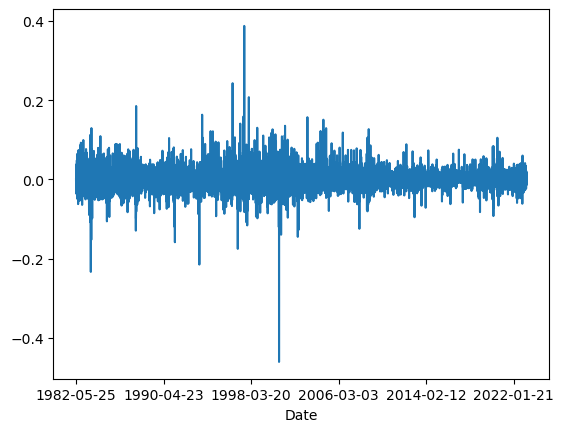

In [7]:
# View data_with_TAs
data_with_TAs['High']['AAPL'].plot()

In [ ]:
%matplotlib inline

# plots all features for Apple. Not needed--just a visual check of the data.
for i in np.unique([ta[0] for ta in data_with_TAs.keys()]):
    fig, ax = plt.subplots()
    ax.plot(data_with_TAs[i]['AAPL'])
    
    ax.set_title(i)
    
    # Setting tick positions every 500 observations, to prevent a ugly mess!
    tick_positions = np.arange(0, len(data_with_TAs[i]['AAPL']), 500)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(data_with_TAs[i]['AAPL'].index[::500], rotation=45)

    plt.show()

In [6]:
# Create a features/technical indicators DataFrame for training and testing.
# Here, we're using 90% of data to train and 10% of data to test.
training_examples = data_with_TAs.iloc[:9262]

# the test data start 1 index higher than training examples ends, so we don't include the last training
# target data in the test training features.
test_examples = data_with_TAs.iloc[9263:-1] # we have to leave off the last example as a target.

training_examples.to_hdf('training_examples.h5', key='data')
test_examples.to_hdf('test_examples.h5', key='data')

In [10]:
training_examples = pd.read_hdf('training_examples.h5', key='data')
training_examples

Adj Close                                                     
                   A       AAL       AAP      AAPL      ABBV       ABC   
Date                                                                     
1982-05-25  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  \
1982-05-26  0.000000  0.000000  0.000000 -0.008695  0.000000  0.000000   
1982-05-27  0.000000  0.000000  0.000000 -0.017543  0.000000  0.000000   
1982-05-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1982-06-01  0.000000  0.000000  0.000000 -0.017856  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2019-02-11  0.003694  0.016389  0.016748 -0.005751  0.001255 -0.007947   
2019-02-12  0.013013 -0.022957  0.016714  0.008617  0.002006  0.025705   
2019-02-13  0.002335  0.012867 -0.008517 -0.004155  0.010760  0.007227   
2019-02-14 -0.002977 -0.002762  0.013697  0.003643 -0.003342  0.000463   
2019-02-15  0.016619 -0.029355  0.007408 -0.002225  0.004099  0.007089   

                                                    ... CDLTAKURI           
                 ABT      ACGL       ACN      ADBE  ...      WYNN XEL XOM   
Date                                                ...                     
1982-05-25 -0.004220  0.000000  0.000000  0.000000  ...         0   0   0  \
1982-05-26 -0.012711  0.000000  0.000000  0.000000  ...         0   0   0   
1982-05-27 -0.004291  0.000000  0.000000  0.000000  ...         0   0   0   
1982-05-28 -0.004310  0.000000  0.000000  0.000000  ...         0   0   0   
1982-06-01  0.000000  0.000000  0.000000  0.000000  ...         0   0   0   
...              ...       ...       ...       ...  ...       ...  ..  ..   
2019-02-11  0.002864  0.000660 -0.001735  0.005409  ...         0   0   0   
2019-02-12  0.020669  0.016485  0.008434  0.011533  ...         0   0   0   
2019-02-13 -0.009059  0.036653  0.008938 -0.004362  ...         0   0   0   
2019-02-14 -0.005512 -0.026283 -0.001139 -0.000346  ...         0   0   0   
2019-02-15  0.017304  0.012211  0.008742 -0.002652  ...         0   0   0   

                                           
           XRAY XYL YUM ZBH ZBRA ZION ZTS  
Date                                       
1982-05-25    0   0   0   0    0    0   0  
1982-05-26    0   0   0   0    0    0   0  
1982-05-27    0   0   0   0    0    0   0  
1982-05-28    0   0   0   0    0    0   0  
1982-06-01    0   0   0   0    0    0   0  
...         ...  ..  ..  ..  ...  ...  ..  
2019-02-11    0   0   0   0    0    0   0  
2019-02-12    0   0   0   0    0    0   0  
2019-02-13    0   0   0   0    0    0   0  
2019-02-14    0   0   0   0    0    0   0  
2019-02-15    0   0   0   0    0    0   0  

[9262 rows x 54609 columns]

In [ ]:
test_examples = pd.read_hdf('test_examples.h5', key='data')
test_examples

In [168]:
# We want to have classes with approximately the same number of observations AND
# we want 3 classes (price goes up/down/flat). So, we use 33% quantiles. 
appl_down = np.round(data_with_TAs['High']['AAPL'].quantile(0.33)*100,2)
appl_up = np.round(data_with_TAs['High']['AAPL'].quantile(0.67)*100, 2)
print("33% of AAPL daily returns (HIGH) are below: " + str(np.round(data_with_TAs['High']['AAPL'].quantile(0.33)*100,2)))
print("33% of AAPL daily returns (HIGH) are above: " + str(np.round(data_with_TAs['High']['AAPL'].quantile(0.67)*100, 2)))

33% of AAPL daily returns (HIGH) are below: -0.66
33% of AAPL daily returns (HIGH) are above: 0.73


<Axes: ylabel='Density'>

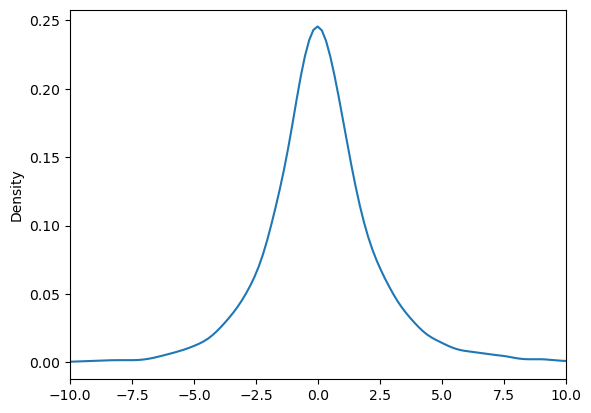

In [169]:
# Plots distribution of Apple's 'High' price, showing it is symmetric, and that
# the calculated quantiles are reasonable.
(data_with_TAs['High']['AAPL']*100).plot(kind='density', xlim=[-10,10])

In [200]:
# Next 3 lines calculates the # of observations between appl_up and appl_down. As expected,
# it's 33% of the observations.
#cond1 = data_with_TAs['High']['AAPL'][14:9262]*100 <= appl_up
#cond2 = data_with_TAs['High']['AAPL'][14:9262]*100 >= appl_down
#print(len(np.where(cond1 & cond2)[0]))

# Creates discretized training target data using quantiles.
# Here we start with 14 because this is the first observation after the 
# first 14 rows of feature data. We stop at 9263, because this is next observation after the
# last row of training feature data.
training_target = np.zeros(len(range(14, 9263)))
training_target[np.where(data_with_TAs['High']['AAPL'][14:9263]*100 >= appl_up)[0]] = 1
training_target[np.where(data_with_TAs['High']['AAPL'][14:9263]*100 <= appl_down)[0]] = -1

test_target = np.zeros(len(range(9277, len(data_with_TAs))))
test_target[np.where(data_with_TAs['High']['AAPL'][9277:]*100 >= appl_up)[0]] = 1
test_target[np.where(data_with_TAs['High']['AAPL'][9277:]*100 <= appl_down)[0]] = -1

# Write training and test target to disk.
pd.DataFrame(training_target).to_hdf('training_target.h5', key='data')
pd.DataFrame(test_target).to_hdf('test_target.h5', key='data')

In [7]:
# Read training and test target to disk (this is just to double-check that the 
# files were created correctly).
training_target = pd.read_hdf('training_target.h5', key='data')
test_target = pd.read_hdf('test_target.h5', key='data')

<Axes: xlabel='Date'>

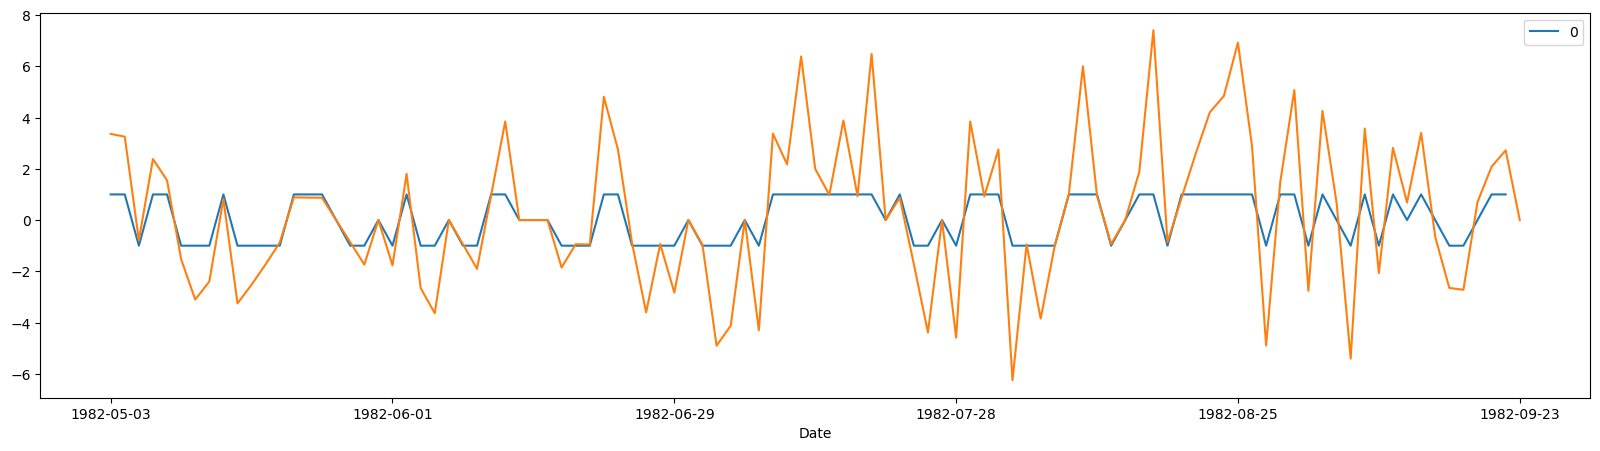

In [203]:
# Illustates that 'High' simple return has been properly discretized for training data
pd.DataFrame(training_target[0:100]).plot()

# Notice that we start with 14 here because the first training example consists of the
# first 14 observations, and the target 'High' (what we're trying to predict) is the next
# day.
#x = data_with_TAs['High']['AAPL'][14:115]*100
x = training_examples['High']['AAPL'][14:115]*100

x.plot(figsize=(20, 5))

<Axes: xlabel='Date'>

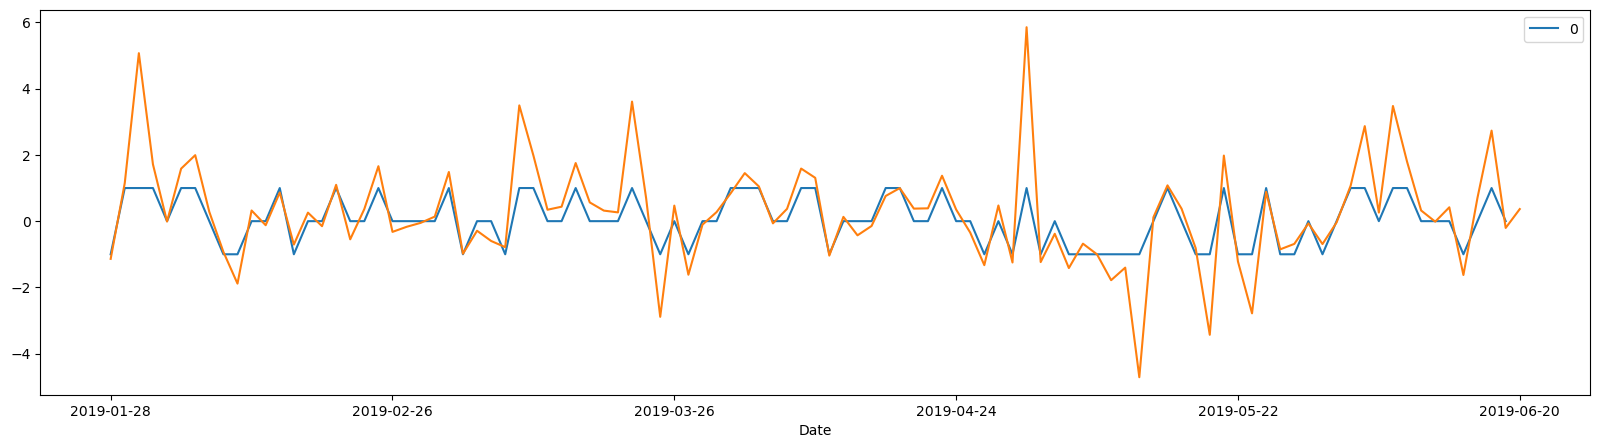

In [204]:
# Illustates that 'High' simple return has been properly discretized for test data
pd.DataFrame(test_target[0:100]).plot()

# Notice that we start with 14 here because the first training example consists of the
# first 14 observations, and the target 'High' (what we're trying to predict) is the next
# day.
x = test_examples['High']['AAPL'][14:115]*100

x.plot(figsize=(20, 5))